In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

In [3]:
# Get mnist dataset
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                                ])
trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
testset = datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)
validset, testset = torch.utils.data.random_split(testset, [int(len(testset)/2), int(len(testset)/2)])

# Create dataloader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)
validloader = torch.utils.data.DataLoader(validset, batch_size=64, shuffle=True)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


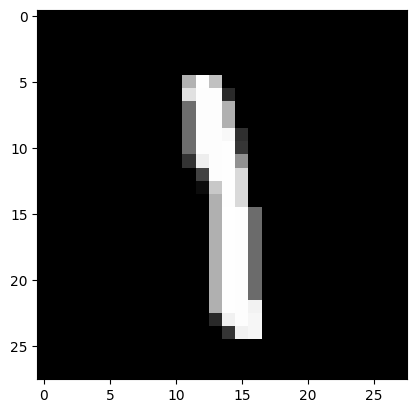

In [4]:
# Visualize some MNIST images
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)
plt.imshow(images[0].numpy().squeeze(), cmap='Greys_r')

In [5]:
# Do K-means clustering on the mnist dataset using tsne
import umap
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale

# Flatten the images
X = trainset.data.numpy().reshape(-1, 28*28)
y = trainset.targets.numpy()
print(X.shape)

# Scale the images
images = scale(X)

# Do umap
pca = PCA(n_components=2, random_state=0)
fit = umap.UMAP(n_neighbors=500)

# tsne = TSNE(n_components=2, random_state=0)
# images_tsne = tsne.fit_transform(images)
# images_pca = pca.fit_transform(images)
images_map = fit.fit_transform(images[:500])

print('done umap')

# Do K-means clustering
kmeans = KMeans(n_clusters=10)
labels = kmeans.fit_predict(images_map)

(60000, 784)
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/stephenlu/anaconda3/envs/ml/lib/python3.11/site-packages/umap/umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


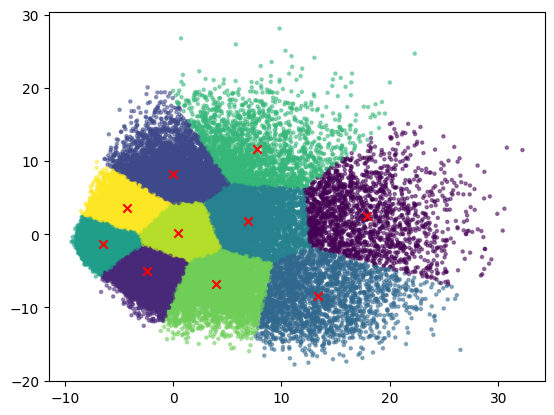

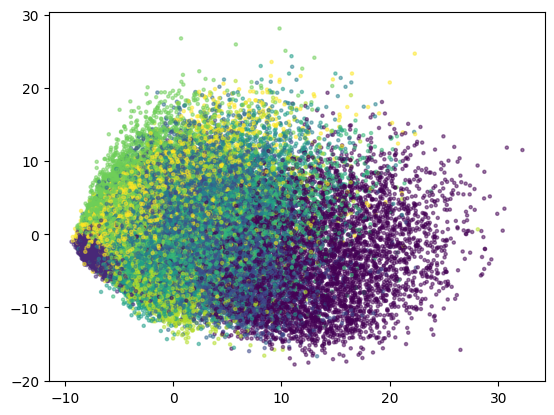

In [44]:
# Plot the results
plt.scatter(images_map[:, 0], images_map[:, 1], c=labels, alpha=0.5, s=5)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='x')
plt.show()

plt.scatter(images_map[:, 0], images_map[:, 1], c=y, alpha=0.5, s=5)
plt.show()

In [45]:
# get closest image to the cluster center
cluster_centers = kmeans.cluster_centers_
for c in cluster_centers:
    dist = np.linalg.norm(images_pca - c, axis=1)
    idx = np.argmin(dist)
    plt.imshow(X[idx].reshape(28, 28), cmap='Greys_r')
    plt.show()

ValueError: cannot reshape array of size 784 into shape (5,5)

In [39]:
# Compute distance of each image to the cluster centers
distances = kmeans.transform(images_pca)
print(distances.shape)

# softmax with temperature
def softmax(x, temperature=1.0):
    e_x = np.exp(x/temperature - np.max(x/temperature, axis=1)[:, None])
    return e_x / e_x.sum(axis=1)[:, None]

# Compute the softmax of the distances
distances_softmax = softmax(-distances, temperature=0.1)
print(distances[0])
print(distances_softmax[0])
print(y[0])
print(distances[44])
print(distances_softmax[44])
print(y[44])
print(np.average(np.max(distances_softmax, axis=1)))

(60000, 10)
[20.16852787  1.45792154 13.0358123  14.71414016 10.30074979  6.58603487
 18.53707742  5.28530174  5.19239584  8.97246357]
[5.50641778e-82 1.00000000e+00 5.22227005e-51 2.68518393e-58
 3.94534370e-39 5.35656988e-23 6.70144499e-75 2.38725592e-17
 6.04483099e-17 2.31610697e-33]
tensor(5)
[23.19363225 10.90543937  5.75668902 23.15927795 12.65320471  6.9462594
 14.23153742 15.3391977   7.72140996  2.20047326]
[6.72773548e-92 1.56607485e-38 3.59377734e-16 9.48566450e-92
 4.02127783e-46 2.45082686e-21 5.62020590e-53 8.69450233e-58
 1.05408720e-24 1.00000000e+00]
tensor(3)
0.983992200420722


In [38]:
# Train a simple neural network on the mnist dataset
from torch import nn, optim

model = nn.Sequential(nn.Linear(784, 128),
                        nn.ReLU(),
                        nn.Linear(128, 64),
                        nn.ReLU(),
                        nn.Linear(64, 10),
                        nn.LogSoftmax(dim=1))

model2 = nn.Sequential(nn.Linear(784, 128),
                        nn.ReLU(),
                        nn.Linear(128, 64),
                        nn.ReLU(),
                        nn.Linear(64, 10),
                        nn.LogSoftmax(dim=1))

criterion = nn.CrossEntropyLoss(label_smoothing=0.02)
criterion2 = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.01)
optimizer2 = optim.SGD(model2.parameters(), lr=0.01)

epochs = 10

num_batches = X.shape[0] // 64
num_iterations = num_batches

X = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y, dtype=torch.long)
y_smoothed = torch.tensor(distances_softmax, dtype=torch.float)

for e in range(epochs):
    running_loss = 0
    running_loss2 = 0
    running_accuracy = 0
    running_accuracy2 = 0

    for i in range(num_iterations):
        start_idx = i * 64
        end_idx = start_idx + 64
        x_batch = X[start_idx : end_idx]
        y_batch = y[start_idx : end_idx]
        y_smoothed = y_smoothed[start_idx : end_idx]

        y_hat_batch = model.forward(x_batch)
        y_hat_batch2 = model2.forward(x_batch)

        loss = criterion(y_hat_batch, y_batch)
        loss2 = criterion2(y_hat_batch2, y_batch)

        accuracy = (y_batch == y_hat_batch.argmax(dim=1)).float().mean()
        accuracy2 = (y_batch == y_hat_batch2.argmax(dim=1)).float().mean()
        
        running_loss += loss.item()
        running_loss2 += loss2.item()
        running_accuracy += accuracy.item()
        running_accuracy2 += accuracy2.item()

        loss.backward()
        loss2.backward()

        optimizer.step()
        optimizer2.step()

        optimizer.zero_grad()
        optimizer2.zero_grad()

    loss = running_loss / num_iterations
    loss2 = running_loss2 / num_iterations
    accuracy = running_accuracy / num_iterations
    accuracy2 = running_accuracy2 / num_iterations

    print(f'Accuracy: {accuracy} vs {accuracy2}')
    print(f'Loss: {loss} vs {loss2}')

Accuracy: 0.4752367929562433 vs 0.11596184631803629
Loss: 2.267521504722257 vs 7.130509515454955
Accuracy: 0.5456576840981857 vs 0.19875600320170758
Loss: 1.2473554246708067 vs 2.081084919840956
Accuracy: 0.602187833511206 vs 0.2468649946638207
Loss: 1.0922396231995322 vs 1.90914500332184
Accuracy: 0.6537820170757738 vs 0.144076840981857
Loss: 0.9388805111291696 vs 2.210353632365118
Accuracy: 0.6700240128068303 vs 0.2196338046958378
Loss: 0.8917676384064788 vs 2.0515786214724674
Accuracy: 0.7734458377801494 vs 0.2622565368196371
Loss: 0.8032480429305339 vs 1.8901416724875744
Accuracy: 0.8480022678762006 vs 0.13035285485592316
Loss: 0.6609197792655758 vs 2.2468504219961014
Accuracy: 0.8619096851654215 vs 0.09791889007470651
Loss: 0.6140183776521632 vs 2.311903150511653
Accuracy: 0.8625266808964781 vs 0.111676227321238
Loss: 0.6151500721496859 vs 2.303080372520292
Accuracy: 0.8718983457844184 vs 0.11237660085378869
Loss: 0.5776270891171 vs 2.301502653476141
